# Tutorial 7: Classification Models

In [2]:
from importlib import reload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sys
import os
import statsmodels.api as sm
import warnings
from sklearn.model_selection import train_test_split
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve, plot_roc
from sklearn.metrics import precision_recall_fscore_support
from PIL import Image

In [3]:
FDA_DIR = os.path.join(os.getcwd(), os.pardir, r'PycharmProjects/Financial-Data-Analytics')
DATA_DIR = rf'{FDA_DIR}/Datasets'

def read_file(filename, dir=None, static=False, **kwargs):
    if dir is None:
        dir = DATA_DIR
        
    path = os.path.join(dir, filename)
    extension = filename.rsplit('.', 1)[-1]

    if extension == 'csv':
        return pd.read_csv(path, **kwargs)
    elif extension in ['parq', 'parquet']:
        return pd.read_parquet(path, **kwargs)
    elif extension == 'json':
        with open(path, 'r') as file:
            return json.load(file)
    elif extension == 'xlsx':
        return pd.read_excel(path, **kwargs)
    else:
        raise NotImplementedError

In [4]:
from rpy2.robjects.packages import importr, data
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

def convert_to_R_df(df):
    with ro.conversion.localconverter(ro.default_converter + pandas2ri.converter):
        r_df = ro.conversion.py2rpy(df)
    return r_df

def convert_from_R_df(r_df):
    with ro.conversion.localconverter(ro.default_converter + pandas2ri.converter):
        df = ro.conversion.rpy2py(r_df)
    return df

def fetch_r_data(name, package):
    package = importr(package)
    df = data(package).fetch(name)[name]
    df = convert_from_R_df(df)
    return df

In [5]:
def confusion_matrix_metrics(y_test, y_pred):
    y_test = pd.Series(np.array(y_test), name='truth')
    y_pred = pd.Series(np.array(y_pred), name='pred')

    all_classes = np.sort(pd.concat([y_test, y_pred]).unique())
    
    conf_mat = y_pred.groupby([y_pred, y_test]).count().unstack()
    conf_mat = conf_mat.reindex(all_classes).reindex(all_classes, axis=1).fillna(0).astype(int)
    
    test_stat = precision_recall_fscore_support(y_test, y_pred, labels=all_classes, zero_division=np.nan)
    test_stat = pd.DataFrame({stat: score for stat, score in 
                              zip(['precision', 'recall', 'fscore', 'support'], test_stat)},
                              index=all_classes)
    return conf_mat, test_stat

## 1. ROC, Gain and Lift Chart

### 1.1 ROC

TPR and FPR are computed to see whether a classification method is effective enough. 

Ideally, an efficient classification tool should maximize the TPR as much as possible while at the same time reduce the FPR; 

the latter mutual relation can be better understood by using the <b>Receiver Operating Characteristic</b> (<b>ROC</b>) curve. 

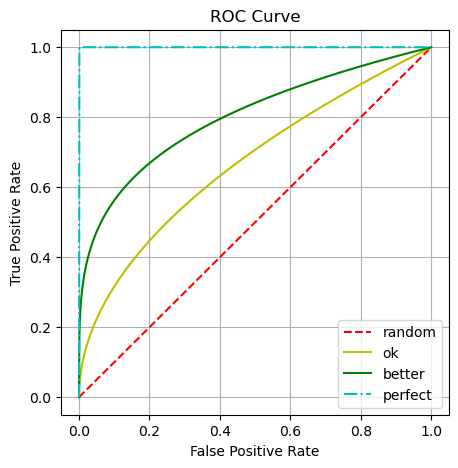

In [9]:
x = np.linspace(0, 1, 1000)
roc_curves = pd.DataFrame({'random': x,
                          'ok': x ** (1 / 2),
                          'better': x ** (1 / 4),
                          'perfect': (x > 0).astype(float)},
                         index=x)

roc_curves.plot(figsize=(5, 5), title='ROC Curve',
                style=['--', '-', '-', '-.'], color=['r', 'y', 'g', 'c']);

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid();
plt.show();

### 1.1.1 Computation of ROC

At each threshold $s$, we can label samples as positive when the score (i.e. predicted probability) $\ge s$.

Higher threshold $s$ will have fewer positive test results.

Thus, $TPR(s), FPR(s)$ are decreasing functions of $s$.

$ROC$ is the plot of $(FPR(s), TPR(s))$

### 1.1.2 Multiclass ROC

If there are multiple classes, which will be discussed later in Section 2. We can calculate an aggregated metric as follows:

Since there is one single ROC for each of the class, we can aggregate roc curves for all classes using ```micro-average``` or ```macro-average```.

Micro-Average:
\begin{equation}
TPR = \frac{\sum_c TP_c}{\sum_c TP_c + FN_c}, \qquad FPR = \frac{\sum_c FP_c}{\sum_c FP_c + TN_c}
\end{equation}
The ratio is computed by first aggregating $TP_c$ for all class

\
Macro-Average:
\begin{equation}
TPR = \frac{1}{C} \sum_c \frac{TP_c}{TP_c + FN_c}, \qquad FPR = \frac{1}{C} \sum_c \frac{FP_c}{FP_c + TN_c}
\end{equation}
Macro-Average treats all classes equally by computing $TPR_c$, and then average across classes.

### 1.2 Gain and Lift Chart

#### 1.2.1 Computation

1. After model fitting, we have $\hat{p}_{1i}$, the predicted probability of $\mathbb{P}(Y_i =1|x_i)$. 

2. Rank $Y_i$ according to the <b>decreasing</b> order of the $\hat{p}_{1i}$.

3. Compute the cumulative sum of correctly labelled $Y_i=1$ according to the ranking

4. Normalize the sum by the total class size of $Y_i=1$ into percentage.
   
5. Plot the cumulative % against the population %.


After these 5 steps, we obtain a ```Gain Chart```.

And ```Lift Chart``` is simply the ratio of the Gain of our model to the Gain of random guessing.

So, it is dividing step (5) by the population % (x-axis).

#### 1.2.2 Intuition and Example

For gain chart, we would expect that most of the records with $Y_i=1$ will be identified when $\hat{p}_{1i}$ is high.

In simple term, it represents the fraction of correctly identified positives among the samples with highest predicted probabilities.

For example, if "Gain at $20 \%$ of population $= 90 \%$", it means we can correctly identify 90% of positives among samples with top 20% scores.

Lift at 20% of population is thus $90\% / 20\% = 4.5$, it means our model is as $4.5$ times powerful as a random guess.

### 1.3 Demo on Default Dataset

We will analyze a default risk dataset in this example. 

The dataset include the balance and income of the borrower, and the label (if he did default at last). 

We will implement logistic regression and do the model evaluation.

In [21]:
default_df = fetch_r_data(name='Default', package='ISLR')
default_df.default = (default_df.default == 'Yes').astype(int)
default_df.student = (default_df.student == 'Yes').astype(int)
default_df

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879
...,...,...,...,...
9996,0,0,711.555020,52992.378914
9997,0,0,757.962918,19660.721768
9998,0,0,845.411989,58636.156984
9999,0,0,1569.009053,36669.112365


In [22]:
# Data Processing
y = default_df.default
X = default_df.drop(columns='default')
X = sm.add_constant(X)

#### 1.3.1 Train Test Split

In [24]:
test_size = 0.2
random_state = 12345
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [25]:
mod = sm.Logit(y_train, X_train).fit()
mod.summary()

Optimization terminated successfully.
         Current function value: 0.083946
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7996
Method:                           MLE   Df Model:                            3
Date:                Wed, 05 Nov 2025   Pseudo R-squ.:                  0.4452
Time:                        21:58:11   Log-Likelihood:                -671.57
converged:                       True   LL-Null:                       -1210.4
Covariance Type:            nonrobust   LLR p-value:                2.559e-233
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.5569      0.521    -20.254      0.000     -11.578      -9.535
student       -0.6438      0.252     -2.559      0.010      -1.137      -0.151
balance        0.0055      0.000     22.592      0.000       0.005       0.006
income      6.677e-06    8.7e-06      0.767      0.443   -1.04e-05    2.37e-05
==============================================================================

Possibly complete quasi-separation: A fraction 0.12 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

#### 1.3.2 Gain and Lift Chart

In [27]:
y_test = y_test.rename('truth')
y_pred = mod.predict(X_test).to_frame(1)
y_pred[0] = 1 - y_pred[1]
y_pred = y_pred.sort_index(axis=1)
y_pred

,0,1
7868,0.806187,0.193813
1403,0.724805,0.275195
8607,0.998893,0.001107
8886,0.999187,0.000813
6495,0.991023,0.008977
...,...,...
2564,0.999792,0.000208
1168,0.984128,0.015872
1010,0.999863,0.000137
1003,0.999968,0.000032


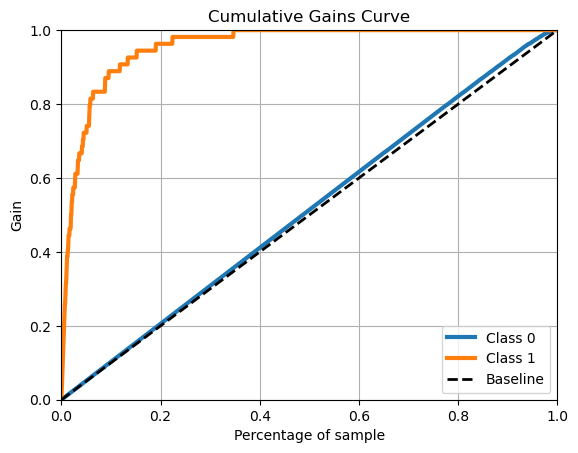

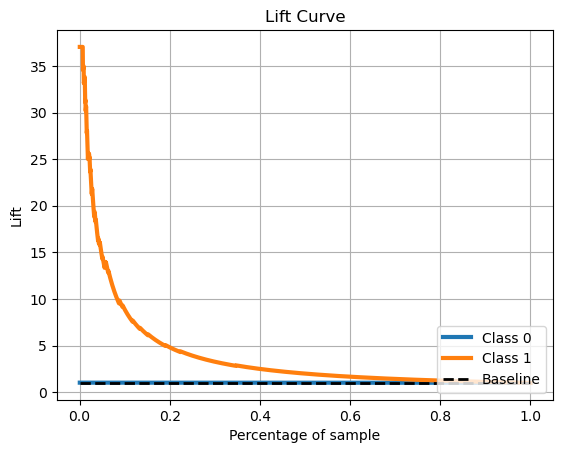

In [28]:
plot_cumulative_gain(y_test, y_pred);
plot_lift_curve(y_test, y_pred);

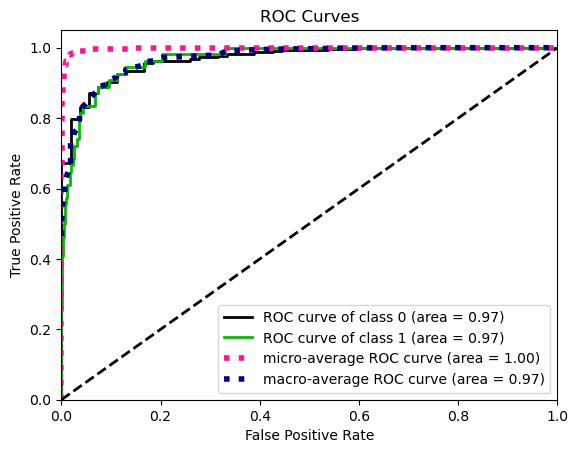

In [29]:
plot_roc(y_test, y_pred);

In [30]:
y_pred_label = y_pred.idxmax(axis=1)
conf_mat, test_stat = confusion_matrix_metrics(y_test, y_pred_label)
display(conf_mat, test_stat)

truth,0,1
pred,,
0,1942,33
1,4,21


,precision,recall,fscore,support
0,0.983291,0.997945,0.990564,1946
1,0.840000,0.388889,0.531646,54


We can see that we have a recall rate of $21 / (21+33) = 39\%$, the performance is not satisfactory in case where False Negative is costly.

This is because we have severely imbalanced classes. This can be resolved by stratified split in ```train_test_splits()```.

You can try it out and see how ROC changes.

## 2. Multinomial Logit Model

The logistic regression model considered previously, where $y_i=1$ with probability $\pi$ and $y_i=0$ with probability $1-\pi_i$,

can be extended to the case where we have $K$ possible outcomes for $y_i$. 


\
In multinomial regression, we instead model

\begin{equation*}
	\mathbb{P}(y_i = k) = \pi_{ik} = \frac{\exp(\mathbf \beta_k^\top \mathbf x_i)}{\sum_{k=1}^K \exp(\mathbf \beta_k^\top \mathbf x_i)} \, , \qquad k=1, \cdots, K \, .
\end{equation*}

One problem with this model is that it is unidentifiable, since we have the constraint $\sum_{k=1}^K \pi_{ik}=1$, for $i=1, \cdots, n$,

the $\mathbf \beta_k$'s cannot be uniquely estimated unless we set one to be zero. 

It does not matter which we set to be zero, suppose that we set $\mathbf \beta_1 = \mathbf 0$. 

Then we have
\begin{align*}
	\mathbb{P}(y_i = k) &= \pi_{ik} = \frac{\exp(\mathbf \beta_k^\top \mathbf x_i)}{\sum_{k=1}^K \exp(\mathbf \beta_k^\top \mathbf x_i)} \, , \qquad k=2, \cdots, K \, , \\
	\mathbb{P}(y_i = 1) &= \pi_{i1} = \frac{1}{\sum_{k=1}^K \exp(\mathbf \beta_k^\top \mathbf x_i)} \, .
\end{align*}

Multinomial logit model can be fit using the ```MNLogit``` in ```statsmodels```. 

The syntax is functionally identical to when fitting ```OLS``` and ```Logit```.

### 2.1 Demo on Glass Dataset

In [35]:
glass_df = fetch_r_data(name='Glass', package='mlbench')
glass_df

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
210,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
211,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
212,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
213,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


In [36]:
# Data Preprocessing
X = glass_df.drop(columns='Type')
X = sm.add_constant(X)

# Manually map categories into [0, 1, ...]
y = glass_df['Type'].astype(int)
y_to_idx = {y: i for i, y in enumerate(y.unique())}
y = y.map(y_to_idx)

In [37]:
for method in ['newton', 'nm', 'bfgs', 'lbfgs', 'powell', 'cg', 'ncg', 'basinhopping', 'minimize']:
    with warnings.catch_warnings(action="ignore"):
        mod = sm.MNLogit(y, X).fit(method=method, maxiter=100, disp=0)
    if not np.isnan(mod.llf):
        print(method, mod.llf)

nm -382.18799577471015
bfgs -161.44600597716425
lbfgs -182.75463737662795
cg -205.85141901015956
ncg -148.1609507523163
minimize -161.44600597716425


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3059: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3060: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)


In [38]:
idx_to_y = {i: y for y, i in y_to_idx.items()}
mod = sm.MNLogit(y, X).fit(method='ncg', maxiter=100, disp=0)
mod.params.rename(columns=idx_to_y).rename_axis('labels', axis=1)

labels,1,2,3,5,6
const,64.374723,324.632492,90.515153,-8.991276,-190.673404
RI,114.570415,-189.440477,63.798563,-11.238008,168.683192
Na,-1.609515,0.905753,-2.010633,4.544589,1.356382
Mg,-4.036545,-0.555416,-5.257172,-2.969275,-5.656936
Al,1.859023,1.634216,8.849700,8.566947,5.993545
Si,-2.520644,-0.707574,-1.958723,-0.386560,-0.698888
K,-1.630174,-1.253376,-0.905623,-41.172178,-0.842834
Ca,-2.501926,0.162112,-2.020519,-0.955197,-3.023952
Ba,-3.789836,-2.539511,-5.135736,-17.225976,-3.128958
Fe,2.681691,1.161522,-2.876545,-21.482603,-12.329191


In [39]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                   Type   No. Observations:                  214
Model:                        MNLogit   Df Residuals:                      164
Method:                           MLE   Df Model:                           45
Date:                Wed, 05 Nov 2025   Pseudo R-squ.:                  0.5411
Time:                        21:58:12   Log-Likelihood:                -148.16
converged:                       True   LL-Null:                       -322.85
Covariance Type:            nonrobust   LLR p-value:                 1.049e-48
==============================================================================
    Type=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.3747    342.522      0.188      0.851    -606.956     735.705
RI           114.5704    208.126      0.550      0.582    -293.349     522.490
Na            -1.6095      1.800     -0.894      0.371      -5.138       1.919
Mg            -4.0365      1.971     -2.048      0.041      -7.899      -0.174
Al             1.8590      2.164      0.859      0.390      -2.382       6.100
Si            -2.5206      1.787     -1.411      0.158      -6.023       0.982
K             -1.6302      2.490     -0.655      0.513      -6.510       3.249
Ca            -2.5019      1.950     -1.283      0.199      -6.324       1.320
Ba            -3.7898      2.771     -1.368      0.171      -9.220       1.640
Fe             2.6817      2.088      1.284      0.199      -1.411       6.774
------------------------------------------------------------------------------
    Type=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        324.6325    518.113      0.627      0.531    -690.850    1340.115
RI          -189.4405    294.798     -0.643      0.520    -767.233     388.352
Na             0.9058      3.121      0.290      0.772      -5.211       7.022
Mg            -0.5554      3.184     -0.174      0.862      -6.797       5.686
Al             1.6342      3.445      0.474      0.635      -5.118       8.386
Si            -0.7076      3.019     -0.234      0.815      -6.625       5.210
K             -1.2534      3.904     -0.321      0.748      -8.905       6.398
Ca             0.1621      3.193      0.051      0.960      -6.096       6.421
Ba            -2.5395      5.038     -0.504      0.614     -12.414       7.335
Fe             1.1615      3.245      0.358      0.720      -5.199       7.522
------------------------------------------------------------------------------
    Type=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         90.5152   1015.081      0.089      0.929   -1899.008    2080.038
RI            63.7986    585.433      0.109      0.913   -1083.628    1211.226
Na            -2.0106      5.565     -0.361      0.718     -12.918       8.896
Mg            -5.2572      5.802     -0.906      0.365     -16.628       6.114
Al             8.8497      5.925      1.494      0.135      -2.763      20.463
Si            -1.9587      5.623     -0.348      0.728     -12.980       9.063
K             -0.9056      5.894     -0.154      0.878     -12.457      10.646
Ca            -2.0205      5.820     -0.347      0.728     -13.428       9.387
Ba            -5.1357      6.147     -0.835      0.403     -17.184       6.912
Fe            -2.8765      6.240     -0.461      0.645     -15.106       9.353
------------------------------------------------------------------------------
    Type=4       coef    std err          z      P>|z|      [0.025      0.975]
--

In [40]:
y_pred = mod.predict(X).rename(columns=idx_to_y)
y_pred_label = y_pred.idxmax(axis=1)
y_test = y.map(idx_to_y)
conf_mat, test_stat = confusion_matrix_metrics(y_test, y_pred_label)
display(conf_mat, test_stat)

truth,1,2,3,5,6,7
pred,,,,,,
1,51,17,10,0,0,0
2,19,56,7,3,0,2
3,0,0,0,0,0,0
5,0,1,0,9,0,0
6,0,0,0,0,9,0
7,0,2,0,1,0,27


,precision,recall,fscore,support
1,0.653846,0.728571,0.689189,70
2,0.643678,0.736842,0.687117,76
3,NaN,0.000000,0.000000,17
5,0.900000,0.692308,0.782609,13
6,1.000000,1.000000,1.000000,9
7,0.900000,0.931034,0.915254,29


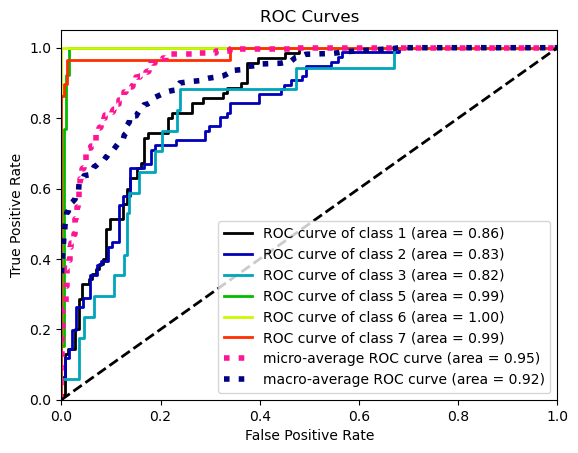

In [41]:
plot_roc(y_test, y_pred);